# Clustering analysis

In [67]:
from scipy.sparse import load_npz, save_npz, csgraph, coo_matrix
import seaborn as sns
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from sklearn import metrics
import pandas as pd
import scipy.sparse.linalg as sps_linalg
import itertools as itt
import altair as alt
from collections import Counter

path = "../../../data/users/summaries/combined/"
int_map_path = path + 'interaction_map-directs-min-100.csv'
adj_matrix_path = path + 'adjacency_matrix.npz'

## Combining interaction maps from the 4 sources into a single map
Fastest to combine interaction map CSVs using command line.

In [ ]:
!f='interaction_map-directs-min-100.csv'
!awk '(NR == 1) || (FNR > 1)' aurimas.eu/$f local/$f vm1/$f vm2/$f > combined/$f

Then, a sparse matrix is created and saved for future use.

In [ ]:
data = np.loadtxt(int_map_path, np.int64, delimiter=',')
adj_matrix = coo_matrix((data[:,2], (data[:, 0], data[:, 1])))
save_npz(adj_matrix_path, adj_matrix)

## TODO: Visualization of user connectedness

<AxesSubplot:ylabel='Count'>

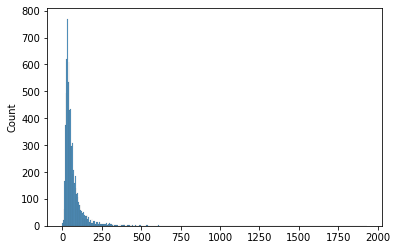

In [38]:
sns.histplot(np.sum(adj_matrix.toarray() > 0, axis=1))

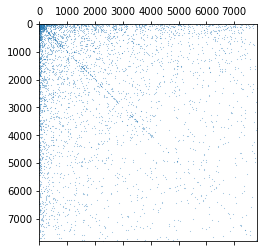

In [56]:
import matplotlib.pylab as plt
t = (adj_matrix.toarray() > 10) * 1
plt.spy(t, markersize=0.1)

## Clustering

  - Remove any "self-interactions" (in the diagonal) in the adjacency matrix
  - Compute Graph Laplacian
  - Retrieve eigenvectors associated with smallest eigenvalues
 

(7809, 7809)

In [86]:

#load the adjacency matrix
adj_matrix = load_npz(adj_matrix_path).tolil()

#set diagonals to zero
adj_matrix.setdiag(0)
A = adj_matrix.toarray()[3:,3:] #exclude skip user and the two bots

#calculate the Graph Laplacian manually
D = np.diag(np.sum(A, axis=1))
L = np.subtract(D, A)
L = L.astype(int)

L.shape


(7807, 7807)

In [87]:
max_clusters=10
vals, vecs = np.linalg.eigh(L)    
selected_vecs = vecs[:, range(max_clusters)]

eigvalues = list(zip(vals, itt.count()))
alt.Chart(pd.DataFrame(eigvalues, columns=['eigenvalue', 'index']).head(30)).mark_line().encode(
    x='index',
    y='eigenvalue'
)


alt.Chart(...)

In [88]:
#Try Kmeans and report scores
results = []
for k in range(2, max_clusters):
    vecs = selected_vecs[:,:k]
    clusters = MiniBatchKMeans(n_clusters=k, max_iter=1000, random_state=42).fit(vecs)
    print(Counter(clusters.labels_))
    s = metrics.silhouette_score(vecs, clusters.labels_)    
    results.append((k, s))

Counter({1: 7805, 0: 2})
Counter({1: 7805, 0: 1, 2: 1})
Counter({2: 4177, 0: 3125, 3: 503, 1: 2})
Counter({1: 7656, 4: 142, 2: 7, 3: 1, 0: 1})
Counter({5: 6788, 1: 765, 4: 241, 2: 11, 3: 1, 0: 1})
Counter({4: 4673, 2: 2985, 3: 102, 6: 32, 0: 7, 5: 7, 1: 1})
Counter({2: 4665, 3: 2149, 4: 862, 6: 60, 0: 46, 7: 10, 5: 8, 1: 7})
Counter({7: 4856, 5: 2376, 6: 332, 8: 170, 4: 23, 1: 20, 3: 17, 2: 12, 0: 1})


In [89]:
clustering_performance = pd.DataFrame(results, columns=["No_clusters", "Silhouette score"])
alt.Chart(clustering_performance).mark_point().encode(
    x="No_clusters",
    y='Silhouette score'
)

alt.Chart(...)

In [90]:
optimal_clusters = 5
vecs = selected_vecs[:,:optimal_clusters]
clusters = MiniBatchKMeans(n_clusters=optimal_clusters, max_iter=1000, random_state=42).fit(vecs)
Counter(clusters.labels_)

Counter({1: 7656, 4: 142, 2: 7, 3: 1, 0: 1})